In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
 
import requests
import sys
import re
 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
import csv
 
import warnings
warnings.filterwarnings("ignore")

# Scrapping data from moneycontrol.com

In [ ]:
money_control_root = 'http://www.moneycontrol.com'

markup = requests.get(money_control_root + '/mutual-funds/amc-assets-monitor').text

soup = BeautifulSoup(markup, "lxml")

# the table that contains the required data
table = soup.find_all('table', attrs = {"class": "tblfund1"})[0]

# get the first ten rows in this table, excluding
# the first row as it has only header information
rows = table.find_all('tr')[1:11] # using top 10 mutual fund families 


# fund_families_schema = StructType([
#     StructField("fund_family", StringType(), True),
#     StructField("fund_family_url", StringType(), True),
#     StructField("fund_family_aum", StringType(), True)
# ])

# Fund Family and Assets under Management (Rs. Cr.) for the top 10 mutual fund families
fund_families = []
for r in rows:
    ff_dict = {
        'fund_family_name':  r.contents[1].a.string ,
        'fund_family_url' :  money_control_root + r.contents[1].a.attrs['href'] ,
        'fund_family_aum' :  r.contents[5].string ,
        'fund_family_shortcode' :  money_control_root + r.contents[1].a.attrs['href'].split('/')[-1]
    }
    
    fund_families.append( ff_dict )

In [ ]:
for x in fund_families:
  print(x)
  print()

In [ ]:
# For each fund family, get a list of all fund schemes along with other details
fund_schemes = []
for fund in fund_families:
    
    markup = requests.get( fund['fund_family_url'] ).text 

    soup = BeautifulSoup(markup, "lxml")

    rows = soup.select('.FL.MT10.boxBg table tr')[1:-1]
    
    for r in rows:
        data_elems      = r.find_all('td')
    
        category_name   = ''
        scheme_aum      = ''
        category_url    = ''
        
        try:
            category_name   = data_elems[2].a.string
            category_url    = money_control_root + data_elems[2].a.attrs['href']
            
        except AttributeError:
            category_name   = u'None'
            category_url    = u'None'
    
        try:
            scheme_aum = data_elems[5].string
        except AttributeError:
            scheme_aum = u'None'

        fscheme_dict    = {
            'fund_family_name'      : fund['fund_family_name'],
            'fund_family_url'       : fund['fund_family_url' ],
            'fund_family_aum'       : fund['fund_family_aum' ],
            'fund_family_shortcode' : fund['fund_family_shortcode'],
            'scheme_name'           : data_elems[0].a.string,
            'scheme_url'            : money_control_root + data_elems[0].a.attrs['href'],
            'crisil_rating'         : data_elems[1].a.string,
            'category'              : category_name,
            'category_url'          : category_url,
            'latest_nav'            : data_elems[3].string,
            '1yr_return'            : u'None' if data_elems[4].string == u'--' else data_elems[4].string,
            'scheme_aum'            : scheme_aum
        }

        fund_schemes.append( fscheme_dict )

# we have to reject few funds due to url issues
reject = []
fund_schemes = [x for x in fund_schemes if x['scheme_url'] not in reject]

In [ ]:
print( len( fund_schemes ))
print()
print()
for x in fund_schemes[:10]:
  print(x)
  print()

In [ ]:
for idx, scheme in enumerate(fund_schemes):

    # Read the page at the URL for each scheme
    markup = requests.get( scheme['scheme_url'] ).text
    soup = BeautifulSoup(markup, "lxml")


    # Riskometer (Risk Rating)
    try:
      scheme['scheme_risk_text'] = soup.select(' #mc_content > .personal_financePg > .section_one > .main_wrapper_res > .common_left > .clearfix > .right_section > .bottom_section > .left_block > .meter_graph > .status')[0].string
    except (IndexError):
      reject.append(scheme['scheme_url'])
      continue


    # From the performance section, gather
    # Fund Returns, Category Avg, Difference of Fund Returns and Category Returns

    try:
      sub_soup = soup.select(' #mc_content > .personal_financePg > .section_four > .main_wrapper_res > .common_left > .returns_table > table > tbody')[0]

      trs = sub_soup.find_all('tr')
      results = []
      for tr in trs:
          tds = tr.find_all('td')
          d = {
              'time': tds[0].text,
              'abs': float(tds[3].text[:-1]),
              'cat': float(tds[5].text[:-1])
          }
          results.append(d)
    
    except (IndexError):
      reject.append(scheme['scheme_url'])
      continue

    # setting initial values as 0.0
    scheme['fund_ret_1m'] = 0.0
    scheme['fund_ret_3m'] = 0.0
    scheme['fund_ret_6m'] = 0.0
    scheme['fund_ret_1y'] = 0.0
    scheme['fund_ret_2y'] = 0.0
    scheme['fund_ret_3y'] = 0.0
    scheme['fund_ret_5y'] = 0.0

    scheme['cat_avg_ret_1m'] = 0.0
    scheme['cat_avg_ret_3m'] = 0.0
    scheme['cat_avg_ret_6m'] = 0.0
    scheme['cat_avg_ret_1y'] = 0.0
    scheme['cat_avg_ret_2y'] = 0.0
    scheme['cat_avg_ret_3y'] = 0.0
    scheme['cat_avg_ret_5y'] = 0.0

    #added actual values

    for x in results:
      if x['time'] == '1 Month':
        scheme['fund_ret_1m'] = x['abs']
        scheme['cat_avg_ret_1m'] = x['cat']
      if x['time'] == '3 Month':
        scheme['fund_ret_3m'] = x['abs']
        scheme['cat_avg_ret_3m'] = x['cat']
      if x['time'] == '6 Month':
        scheme['fund_ret_6m'] = x['abs']
        scheme['cat_avg_ret_6m'] = x['cat']
      if x['time'] == '1 Year':
        scheme['fund_ret_1y'] = x['abs']
        scheme['cat_avg_ret_1y'] = x['cat']
      if x['time'] == '2 Year':
        scheme['fund_ret_2y'] = x['abs']
        scheme['cat_avg_ret_2y'] = x['cat']
      if x['time'] == '3 Year':
        scheme['fund_ret_3y'] = x['abs']
        scheme['cat_avg_ret_3y'] = x['cat']
      if x['time'] == '5 Year':
        scheme['fund_ret_5y'] = x['abs']
        scheme['cat_avg_ret_5y'] = x['cat']



    scheme['diff_fund_cat_1m'] = scheme['fund_ret_1m'] - scheme['cat_avg_ret_1m']
    scheme['diff_fund_cat_3m'] = scheme['fund_ret_3m'] - scheme['cat_avg_ret_3m']
    scheme['diff_fund_cat_6m'] = scheme['fund_ret_6m'] - scheme['cat_avg_ret_6m']
    scheme['diff_fund_cat_1y'] = scheme['fund_ret_1y'] - scheme['cat_avg_ret_1y']
    scheme['diff_fund_cat_2y'] = scheme['fund_ret_2y'] - scheme['cat_avg_ret_2y']
    scheme['diff_fund_cat_3y'] = scheme['fund_ret_3y'] - scheme['cat_avg_ret_3y']
    scheme['diff_fund_cat_5y'] = scheme['fund_ret_5y'] - scheme['cat_avg_ret_5y']
    
    #print( 'Scheme # {0}\n{1}\n\n\n'.format(idx, scheme) )
    print("Scraped {0} / {1} Mutual funds".format(idx+1, len(fund_schemes)))
    

In [ ]:
for x in range(0,len(reject)-1,2):
  print("'",reject[x],"', '",reject[x+1],"'")

In [ ]:
# removing rejected funds (those with bad links)
fund_schemes = [x for x in fund_schemes if x['scheme_url'] not in reject]
print( len( fund_schemes ))
print()
print()
for x in fund_schemes[:10]:
  print(x)
  print()

# Save and Load Data

In [ ]:
#Save the collected data to text, which is then converted to a csv file.
out_path= "./fund_schemes.txt"
out_file = open(out_path, 'w')

fieldnames = sorted(list(set(k for d in fund_schemes for k in d)))
writer = csv.DictWriter(out_file, fieldnames=fieldnames, dialect='excel')

writer.writeheader() 
for row in fund_schemes:
    writer.writerow(row)
out_file.close()

In [ ]:
#loading data from .txt file
reader = csv.DictReader(open("./fund_schemes.txt"))
fund_schemes = []
for raw in reader:
    fund_schemes.append(dict(raw)) 
print( len( fund_schemes ))
print()
print()
for x in fund_schemes[:10]:
  print(x)
  print()

1099


{'1yr_return': '8.0', 'cat_avg_ret_1m': '8.18', 'cat_avg_ret_1y': '9.19', 'cat_avg_ret_2y': '11.15', 'cat_avg_ret_3m': '11.02', 'cat_avg_ret_3y': '8.18', 'cat_avg_ret_5y': '10.8', 'cat_avg_ret_6m': '35.52', 'category': 'Index Funds/ETFs', 'category_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/index-fundsetfs.html', 'crisil_rating': 'Not Ranked', 'diff_fund_cat_1m': '0.14000000000000057', 'diff_fund_cat_1y': '-1.17', 'diff_fund_cat_2y': '9.589999999999998', 'diff_fund_cat_3m': '2.0600000000000005', 'diff_fund_cat_3y': '15.879999999999999', 'diff_fund_cat_5y': '60.06', 'diff_fund_cat_6m': '6.25', 'fund_family_aum': '364,363', 'fund_family_name': 'SBI Mutual Fund', 'fund_family_shortcode': 'http://www.moneycontrol.comSB', 'fund_family_url': 'http://www.moneycontrol.com/mutual-funds/amc-details/SB', 'fund_ret_1m': '8.32', 'fund_ret_1y': '8.02', 'fund_ret_2y': '20.74', 'fund_ret_3m': '13.08', 'fund_ret_3y': '24.06', 'fund_ret_5y': '70.86', 'fund_ret_6m'

# Preprocessing for ML

In [ ]:

'''
Method to convert risk text to a numerical attribute
'''
def encode_risk(risk_text):
    # The higher the risk, the lower the score!
    risk = {
        u'HIGH'              :  1,
        u'MODERATELY HIGH'   :  2,
        u'MODERATE'          :  3,
        u'MODERATELY LOW'    :  4,
        u'LOW'               :  5 
    }
    try:
        return risk[risk_text.upper() ]
    except:
        return 1

'''
Method to convert numerical features that appear as strings or unicode strings into numbers
'''
def to_numeric( text ):
    try:
        return float( re.sub(
            '(Rs[ ]*\.)|[^\d|.|-]|(Rank[ ]*)',
            '',
            text,
            flags = re.IGNORECASE
        ) )
    except:
        return None

In [ ]:
# Initialize a list to store metrics for ris
for idx, scheme in enumerate( fund_schemes ):
    ##
    # Step 1: Convert numerical features appearing as text to numerical features
    #         1.a: Encode risk text to a numerical representation of risk.
    #              Highest risk gets the lowest score, lowest risk gets the highest score
    #
    #         1.b: Convert numbers formatted with commas or currency or rating description to just numbers
    ##
    
    # Convert scheme risk text to a numerical attribute
    fund_schemes[idx]['num_scheme_risk']            = encode_risk( scheme['scheme_risk_text'] )
    
    # Convert metrics to numerical features
    fund_schemes[idx]['num_fund_family_aum']        = to_numeric( scheme['fund_family_aum'] )
 
    fund_schemes[idx]['num_crisil_rating']          = to_numeric( scheme['crisil_rating'] )
 
    fund_schemes[idx]['num_latest_nav']             = to_numeric( scheme['latest_nav'] )
    fund_schemes[idx]['num_1yr_return']             = to_numeric( scheme['1yr_return'] )
    fund_schemes[idx]['num_scheme_aum']             = to_numeric( scheme['scheme_aum'] ) 
 
 
    fund_schemes[idx]['num_fund_ret_1m']            = to_numeric( scheme['fund_ret_1m'] )
    fund_schemes[idx]['num_fund_ret_3m']            = to_numeric( scheme['fund_ret_3m'] )
    fund_schemes[idx]['num_fund_ret_6m']            = to_numeric( scheme['fund_ret_6m'] )
    fund_schemes[idx]['num_fund_ret_1y']            = to_numeric( scheme['fund_ret_1y'] )
    fund_schemes[idx]['num_fund_ret_2y']            = to_numeric( scheme['fund_ret_2y'] )
    fund_schemes[idx]['num_fund_ret_3y']            = to_numeric( scheme['fund_ret_3y'] )
    fund_schemes[idx]['num_fund_ret_5y']            = to_numeric( scheme['fund_ret_5y'] )
 
    fund_schemes[idx]['num_cat_avg_ret_1m']         = to_numeric( scheme['cat_avg_ret_1m'] )
    fund_schemes[idx]['num_cat_avg_ret_3m']         = to_numeric( scheme['cat_avg_ret_3m'] )
    fund_schemes[idx]['num_cat_avg_ret_6m']         = to_numeric( scheme['cat_avg_ret_6m'] )
    fund_schemes[idx]['num_cat_avg_ret_1y']         = to_numeric( scheme['cat_avg_ret_1y'] )
    fund_schemes[idx]['num_cat_avg_ret_2y']         = to_numeric( scheme['cat_avg_ret_2y'] )
    fund_schemes[idx]['num_cat_avg_ret_3y']         = to_numeric( scheme['cat_avg_ret_3y'] )
    fund_schemes[idx]['num_cat_avg_ret_5y']         = to_numeric( scheme['cat_avg_ret_5y'] )
 
    fund_schemes[idx]['num_diff_fund_cat_1m']       = to_numeric( scheme['diff_fund_cat_1m'] )
    fund_schemes[idx]['num_diff_fund_cat_3m']       = to_numeric( scheme['diff_fund_cat_3m'] )
    fund_schemes[idx]['num_diff_fund_cat_6m']       = to_numeric( scheme['diff_fund_cat_6m'] )
    fund_schemes[idx]['num_diff_fund_cat_1y']       = to_numeric( scheme['diff_fund_cat_1y'] )
    fund_schemes[idx]['num_diff_fund_cat_2y']       = to_numeric( scheme['diff_fund_cat_2y'] )
    fund_schemes[idx]['num_diff_fund_cat_3y']       = to_numeric( scheme['diff_fund_cat_3y'] )
    fund_schemes[idx]['num_diff_fund_cat_5y']       = to_numeric( scheme['diff_fund_cat_5y'] )
    
    
    ##
    # Step 2: Calculate additional risk metrics - the fetched risk rating is based on MPT Statistics
    #         which is already a sound measurement. Hence, we devise and incorporate more measures
    #         such as:
    ##
    
    # Score between 0 and 1 based on Risk Rating which is based on MPT Statistics
    fund_schemes[idx]['cstm_mtrc_risk_rating'] = fund_schemes[idx]['num_scheme_risk'] / 5.0
    
    # Score between 0 and 1 based on CRISIL rating
    fund_schemes[idx]['cstm_mtrc_crisil']  = fund_schemes[idx]['num_crisil_rating'] / 5.0 if fund_schemes[idx]['num_crisil_rating'] else 3.0/5.0
    
    # Score between 0 and 1 based on AUM allocation to the scheme compared to other schemes in the fund family
    fund_schemes[idx]['cstm_mtrc_alloc'] = float( fund_schemes[idx]['num_scheme_aum'] ) / ( fund_schemes[idx]['num_fund_family_aum'] ) if fund_schemes[idx]['num_scheme_aum'] and fund_schemes[idx]['num_fund_family_aum'] else 0.0
    
    # Score between 0 and 1 based on fund performance relative to category performance
    fund_schemes[idx]['cstm_mtrc_diff_1m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_1m'] and fund_schemes[idx]['num_diff_fund_cat_1m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_3m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_3m'] and fund_schemes[idx]['num_diff_fund_cat_3m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_6m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_6m'] and fund_schemes[idx]['num_diff_fund_cat_6m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_1y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_1y'] and fund_schemes[idx]['num_diff_fund_cat_1y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_2y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_2y'] and fund_schemes[idx]['num_diff_fund_cat_2y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_3y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_3y'] and fund_schemes[idx]['num_diff_fund_cat_3y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_5y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_5y'] and fund_schemes[idx]['num_diff_fund_cat_5y'] > 0 else 0
    
    
    
    # Initialize a set of lists to contain class labels based on time frame
    normal_scores_1m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1m'],
    ]
    
    normal_scores_3m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3m'],
        
    ]
    
    normal_scores_6m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_6m'],
       
    ]
    
    normal_scores_1y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1y'],
        
    ]
    
    normal_scores_2y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_2y'],
        
    ]
    
    normal_scores_3y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3y'],
        
    ]
    
    normal_scores_5y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_5y'],
        
    ]
    
    
    ##
    # Calculate labels for each time frame based on calculated metrics
    ## 
    ##
    labels_1m = round( float( sum(normal_scores_1m ) ) / max( len( normal_scores_1m ), 1 ) )
    labels_3m = round( float( sum(normal_scores_3m ) ) / max( len( normal_scores_3m ), 1 ) )
    labels_6m = round( float( sum(normal_scores_6m ) ) / max( len( normal_scores_6m ), 1 ) )
    labels_1y = round( float( sum(normal_scores_1y ) ) / max( len( normal_scores_1y ), 1 ) )
    labels_2y = round( float( sum(normal_scores_2y ) ) / max( len( normal_scores_2y ), 1 ) )
    labels_3y = round( float( sum(normal_scores_3y ) ) / max( len( normal_scores_3y ), 1 ) )
    labels_5y = round( float( sum(normal_scores_5y ) ) / max( len( normal_scores_5y ), 1 ) )
 
    # Store the labels for each time frame along with scheme details
    fund_schemes[idx]['calculated_label_1m'] = labels_1m
    fund_schemes[idx]['calculated_label_3m'] = labels_3m
    fund_schemes[idx]['calculated_label_6m'] = labels_6m
    fund_schemes[idx]['calculated_label_1y'] = labels_1y
    fund_schemes[idx]['calculated_label_2y'] = labels_2y
    fund_schemes[idx]['calculated_label_3y'] = labels_3y
    fund_schemes[idx]['calculated_label_5y'] = labels_5y

In [ ]:
##
# Create target values for each time frame
##
Y_1m = np.array( [scheme['calculated_label_1m'] for scheme in fund_schemes] )
Y_3m = np.array( [scheme['calculated_label_3m'] for scheme in fund_schemes] )
Y_6m = np.array( [scheme['calculated_label_6m'] for scheme in fund_schemes] )
Y_1y = np.array( [scheme['calculated_label_1y'] for scheme in fund_schemes] )
Y_2y = np.array( [scheme['calculated_label_2y'] for scheme in fund_schemes] )
Y_3y = np.array( [scheme['calculated_label_3y'] for scheme in fund_schemes] )
Y_5y = np.array( [scheme['calculated_label_5y'] for scheme in fund_schemes] )

In [ ]:
##
# Create feature vectors for each time frame
##
X_1m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_1m'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_1m'] else 0
        ]
        for scheme in fund_schemes
    ]
)

X_3m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_3m']           if scheme['num_fund_ret_3m'] else 0,
            scheme['num_cat_avg_ret_3m']        if scheme['num_cat_avg_ret_3m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_6m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_6m']           if scheme['num_fund_ret_6m'] else 0,
            scheme['num_cat_avg_ret_6m']        if scheme['num_cat_avg_ret_6m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_1y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_1y']           if scheme['num_fund_ret_1y'] else 0,
            scheme['num_cat_avg_ret_1y']        if scheme['num_cat_avg_ret_1y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_2y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_2y']           if scheme['num_fund_ret_2y'] else 0,
            scheme['num_cat_avg_ret_2y']        if scheme['num_cat_avg_ret_2y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_3y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_3y']           if scheme['num_fund_ret_3y'] else 0,
            scheme['num_cat_avg_ret_3y']        if scheme['num_cat_avg_ret_3y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_5y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_fund_ret_5y']           if scheme['num_fund_ret_5y'] else 0,
            scheme['num_cat_avg_ret_5y']        if scheme['num_cat_avg_ret_5y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)



# Handle NaNs using an Imputer

imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

X_1m = imp.fit_transform( X_1m )
X_3m = imp.fit_transform( X_3m )
X_6m = imp.fit_transform( X_6m )
X_1y = imp.fit_transform( X_1y )
X_2y = imp.fit_transform( X_2y )
X_3y = imp.fit_transform( X_3y )
X_5y = imp.fit_transform( X_5y )

# Random Forest Clasifier 

In [ ]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 40
# to find out which trees gives more accuracy.

num_trees = range(1, 41)

# Define folds = N for N-fold cross-validation
num_folds = 10

# Define a DF to store cross validation results
df_rf_1m = pd.DataFrame(columns=['num_trees','score'])
df_rf_3m = pd.DataFrame(columns=['num_trees','score'])
df_rf_6m = pd.DataFrame(columns=['num_trees','score'])
df_rf_1y = pd.DataFrame(columns=['num_trees','score'])
df_rf_2y = pd.DataFrame(columns=['num_trees','score'])
df_rf_3y = pd.DataFrame(columns=['num_trees','score'])
df_rf_5y = pd.DataFrame(columns=['num_trees','score'])


# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in num_trees:    
    forest = RandomForestClassifier(n_estimators = num)
    
    scores_1m = cross_val_score(forest, X_1m[:1000, :], Y_1m[:1000], scoring = 'f1', cv = num_folds)
    scores_3m = cross_val_score(forest, X_3m[:1000, :], Y_3m[:1000], scoring = 'f1', cv = num_folds)
    scores_6m = cross_val_score(forest, X_6m[:1000, :], Y_6m[:1000], scoring = 'f1', cv = num_folds)
    scores_1y = cross_val_score(forest, X_1y[:1000, :], Y_1y[:1000], scoring = 'f1', cv = num_folds)
    scores_2y = cross_val_score(forest, X_2y[:1000, :], Y_2y[:1000], scoring = 'f1', cv = num_folds)
    scores_3y = cross_val_score(forest, X_3y[:1000, :], Y_3y[:1000], scoring = 'f1', cv = num_folds)
    scores_5y = cross_val_score(forest, X_5y[:1000, :], Y_5y[:1000], scoring = 'f1', cv = num_folds)

    for x in scores_1m:
      df_rf_1m.loc[-1] = [num, x]
      df_rf_1m.index = df_rf_1m.index + 1
    
    for x in scores_3m:
      df_rf_3m.loc[-1] = [num, x]
      df_rf_3m.index = df_rf_3m.index + 1
    
    for x in scores_6m:
      df_rf_6m.loc[-1] = [num, x]
      df_rf_6m.index = df_rf_6m.index + 1
    
    for x in scores_1y:
      df_rf_1y.loc[-1] = [num, x]
      df_rf_1y.index = df_rf_1y.index + 1
    
    for x in scores_2y:
      df_rf_2y.loc[-1] = [num, x]
      df_rf_2y.index = df_rf_2y.index + 1
    
    for x in scores_3y:
      df_rf_3y.loc[-1] = [num, x]
      df_rf_3y.index = df_rf_3y.index + 1
    
    for x in scores_5y:
      df_rf_5y.loc[-1] = [num, x]
      df_rf_5y.index = df_rf_5y.index + 1

# Plotting Box plot of Number of trees for all time periods

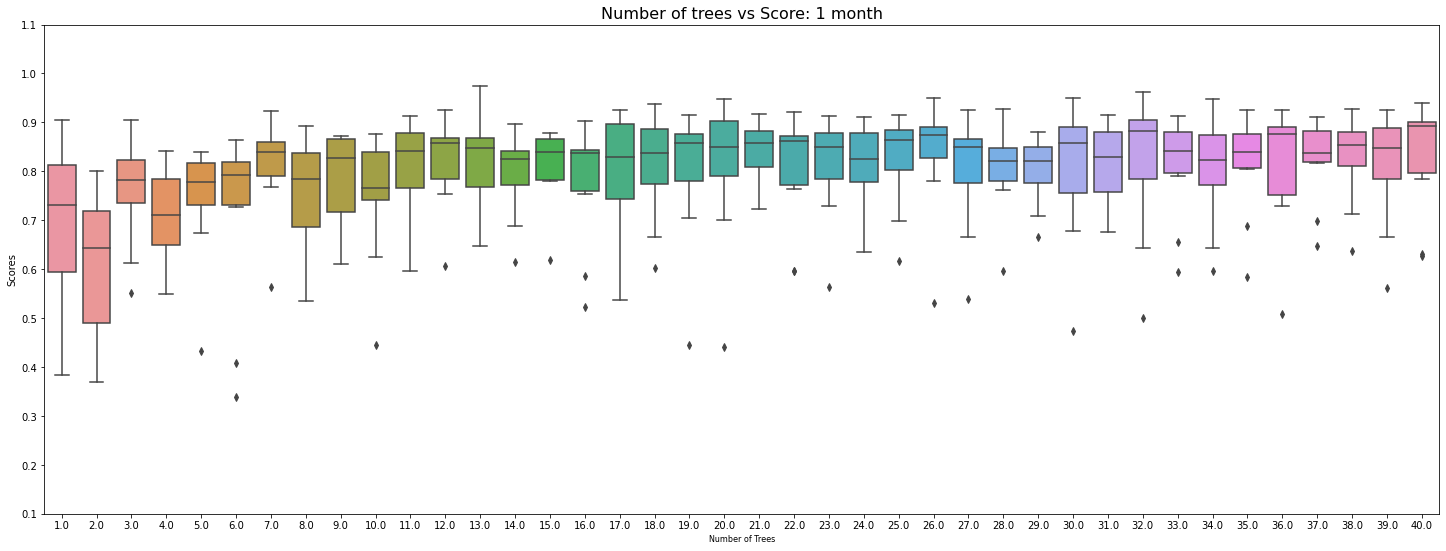

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_1m)

plt.title(  "Number of trees vs Score: 1 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


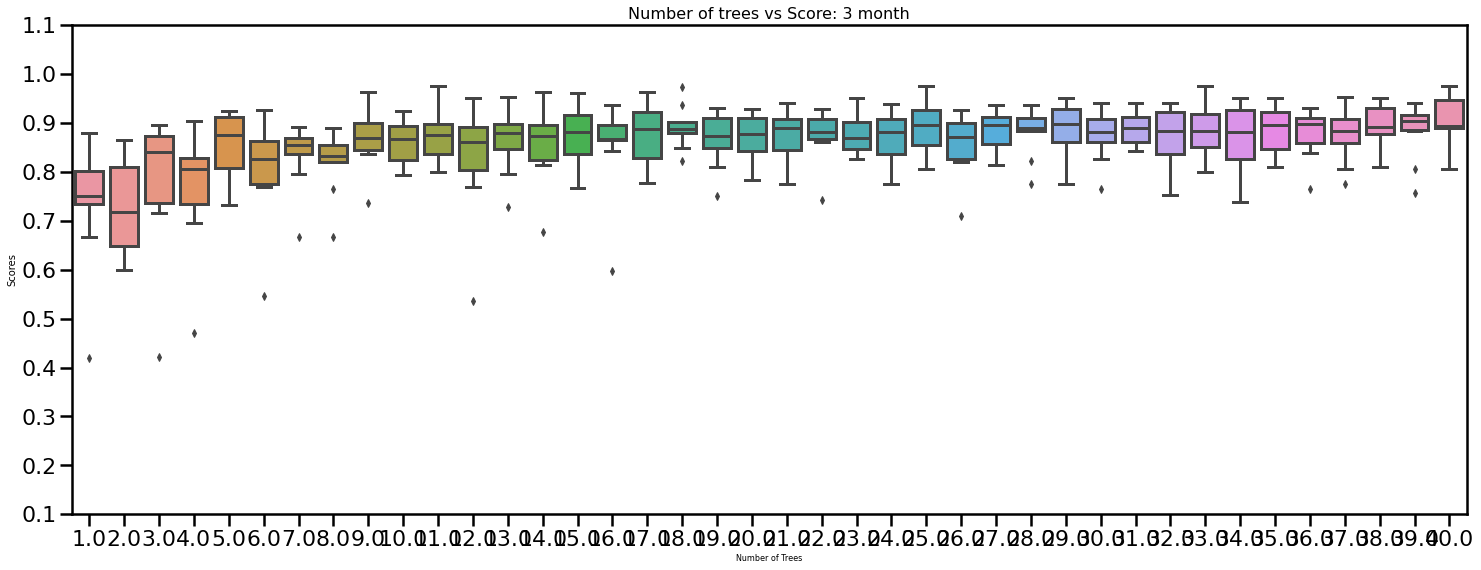

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_3m)

plt.title(  "Number of trees vs Score: 3 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


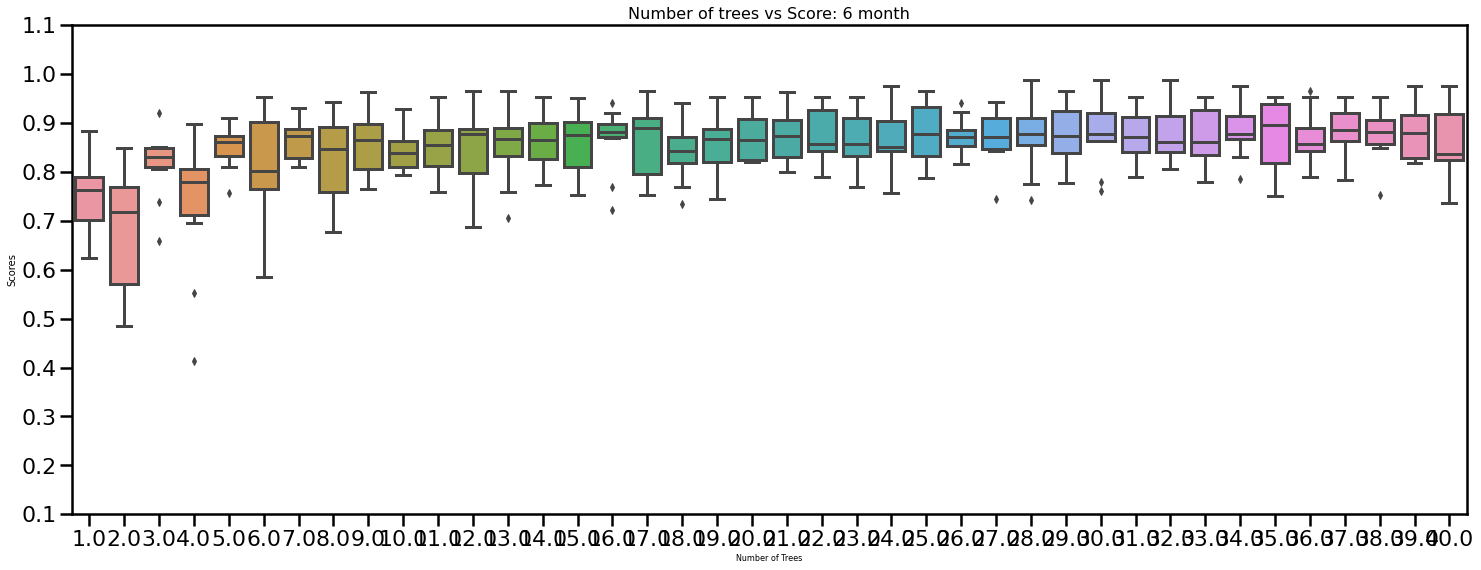

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_6m)

plt.title(  "Number of trees vs Score: 6 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


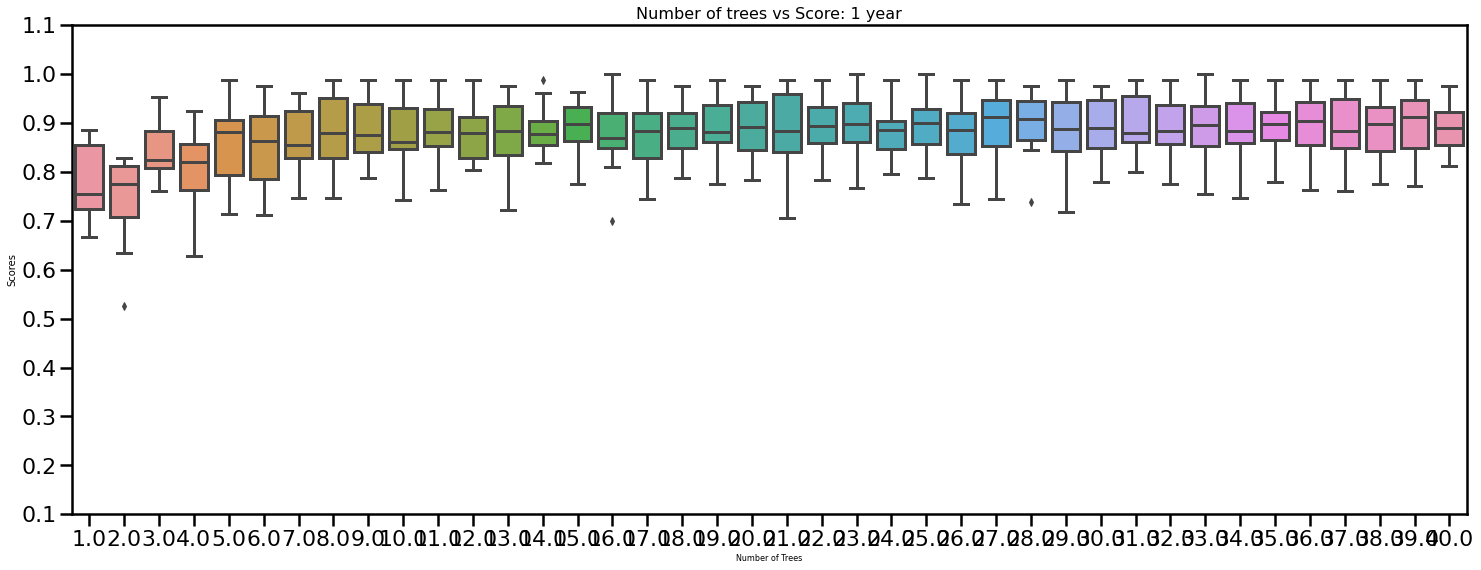

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_1y)

plt.title(  "Number of trees vs Score: 1 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


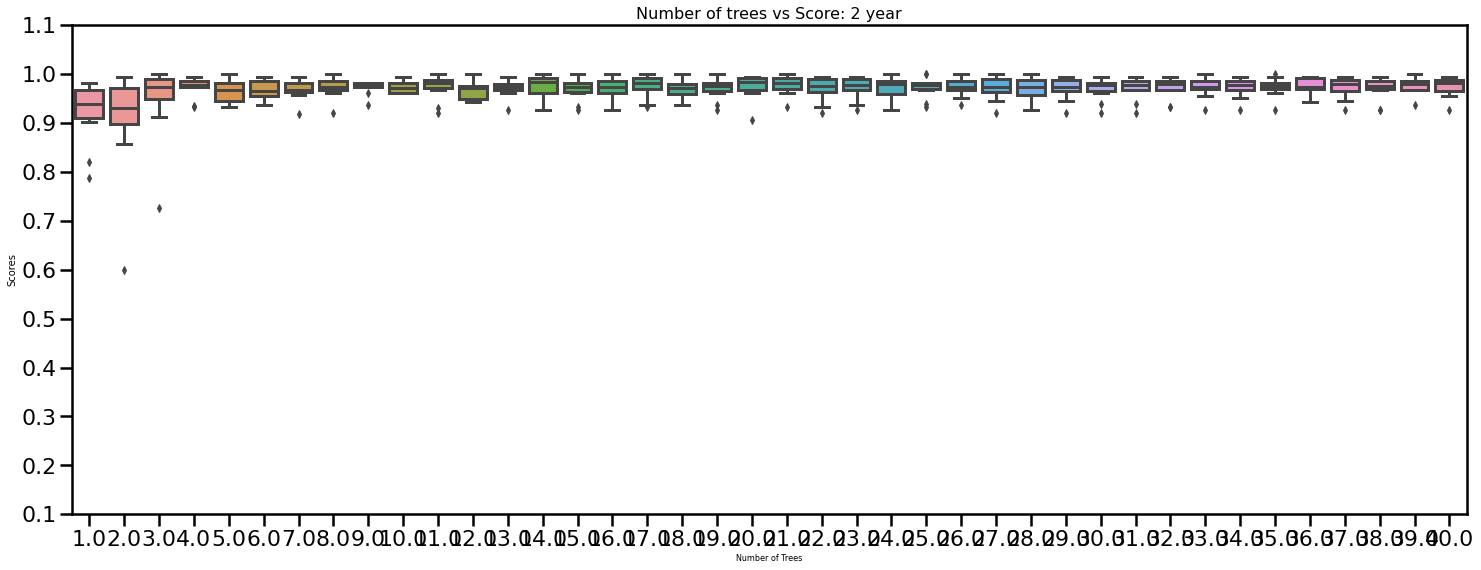

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_2y)

plt.title(  "Number of trees vs Score: 2 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


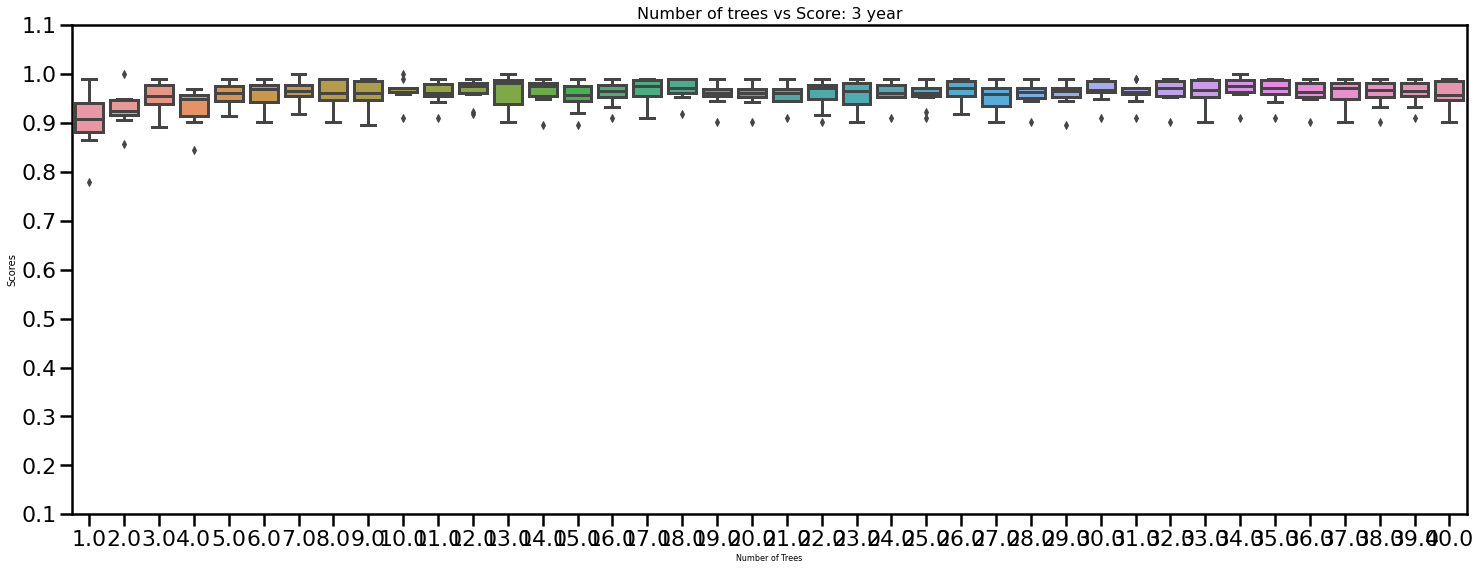

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_3y)

plt.title(  "Number of trees vs Score: 3 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


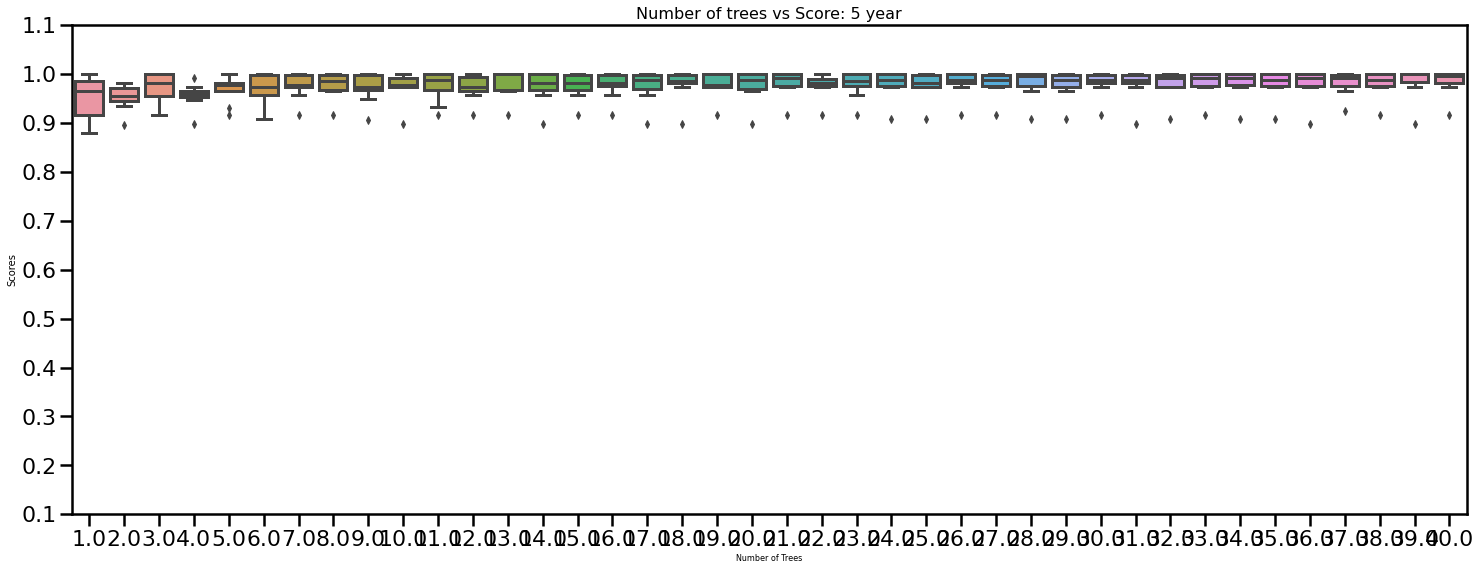

In [ ]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(25,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(x = 'num_trees', y = 'score', data = df_rf_5y)

plt.title(  "Number of trees vs Score: 5 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=8)
plt.ylabel( "Scores", fontsize=10)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


# Selecting best number of trees for all time periods and get feature importance


In [ ]:
##
# 1 month:
##
# Train random forest classifier with the optimal 28 estimators
## 
clf_1m = RandomForestClassifier( n_estimators = 28)
clf_1m = clf_1m.fit( X_1m[:1000, :], Y_1m[:1000] )

##
# 3 month:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_3m = RandomForestClassifier( n_estimators = 20)
clf_3m = clf_3m.fit( X_3m[:1000, :], Y_3m[:1000] )

##
# 6 month:
##
# Train random forest classifier with the optimal 38 estimators
## 
clf_6m = RandomForestClassifier( n_estimators = 38)
clf_6m = clf_6m.fit( X_6m[:1000, :], Y_6m[:1000] )

##
# 1 year:
##
# Train random forest classifier with the optimal 30 estimators
## 
clf_1y = RandomForestClassifier( n_estimators = 30)
clf_1y = clf_1y.fit( X_1y[:1000, :], Y_1y[:1000] )

##
# 2 year:
##
# Train random forest classifier with the optimal 36 estimators
## 
clf_2y = RandomForestClassifier( n_estimators = 36)
clf_2y = clf_2y.fit( X_2y[:1000, :], Y_2y[:1000] )

##
# 3 year:
##
# Train random forest classifier with the optimal 19 estimators
## 
clf_3y = RandomForestClassifier( n_estimators = 19)
clf_3y = clf_3y.fit( X_3y[:1000, :], Y_3y[:1000] )

##
# 5 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_5y = RandomForestClassifier( n_estimators = 20)
clf_5y = clf_5y.fit( X_5y[:1000, :], Y_5y[:1000] )



# obtain the relative importance of the features 
feature_imp_1m = clf_1m.feature_importances_
feature_imp_3m = clf_3m.feature_importances_
feature_imp_6m = clf_6m.feature_importances_
feature_imp_1y = clf_1y.feature_importances_
feature_imp_2y = clf_2y.feature_importances_
feature_imp_3y = clf_3y.feature_importances_
feature_imp_5y = clf_5y.feature_importances_

#get column names
columns = ['Scheme Risk',
            'CRISIL Rating',
            'Fund Family AUM',
            'Scheme AUM',
            'Latest NAV',
            'Fund Return',
            'Category Return'
          ]

# Plotting Feature Importance

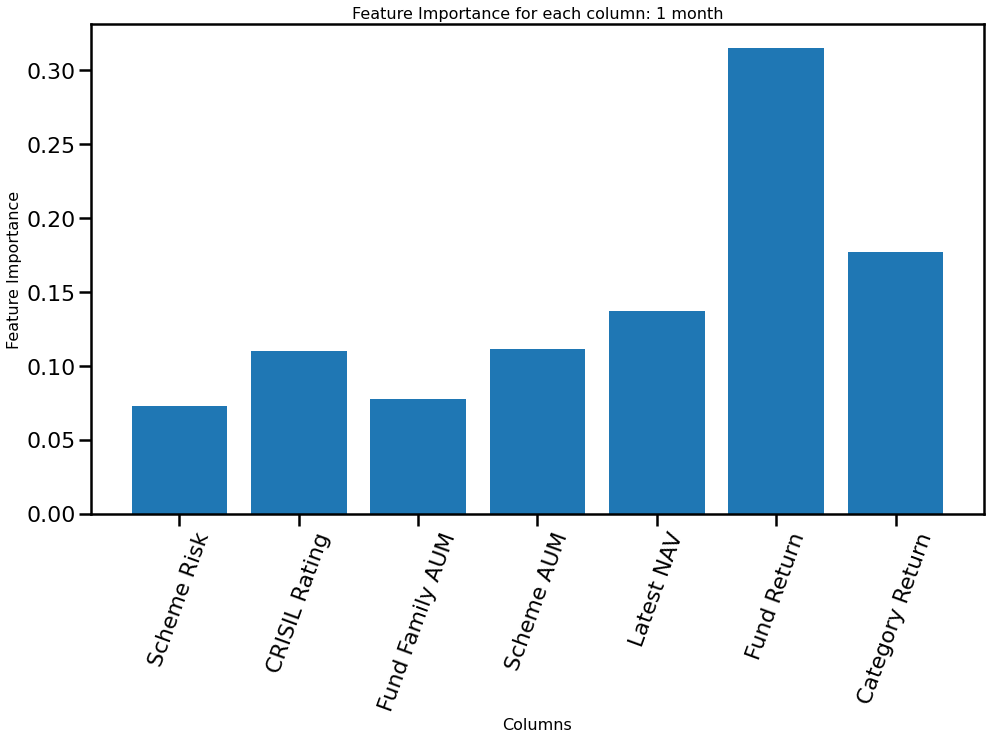

In [ ]:
# 1 month
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_1m)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 month', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

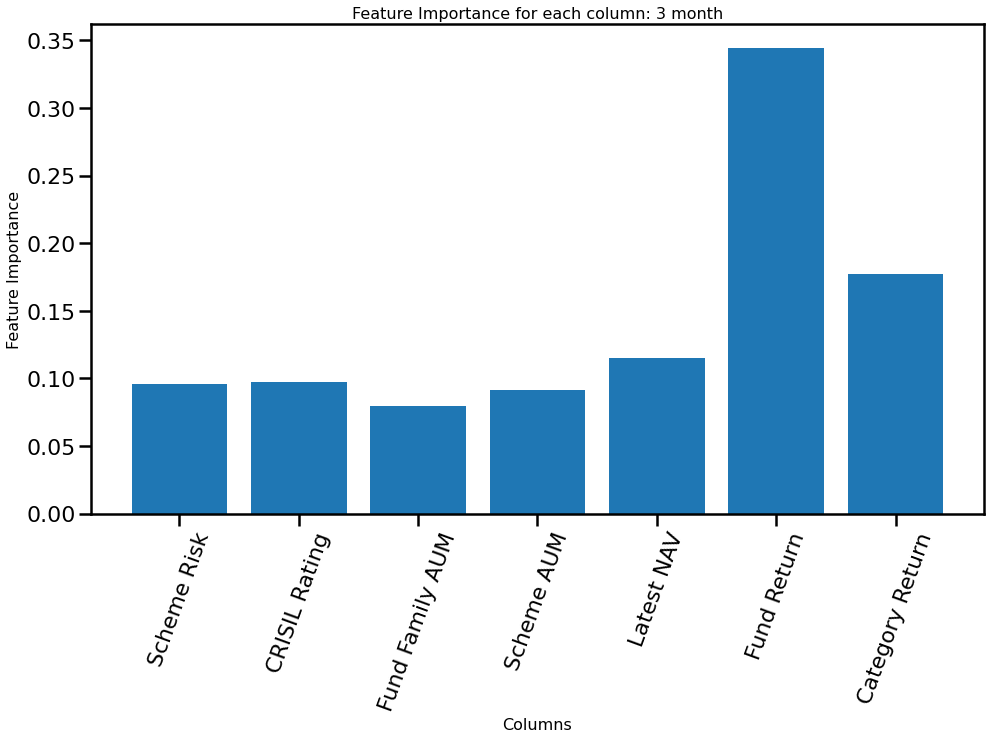

In [ ]:
# 3 month
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_3m)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 month', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

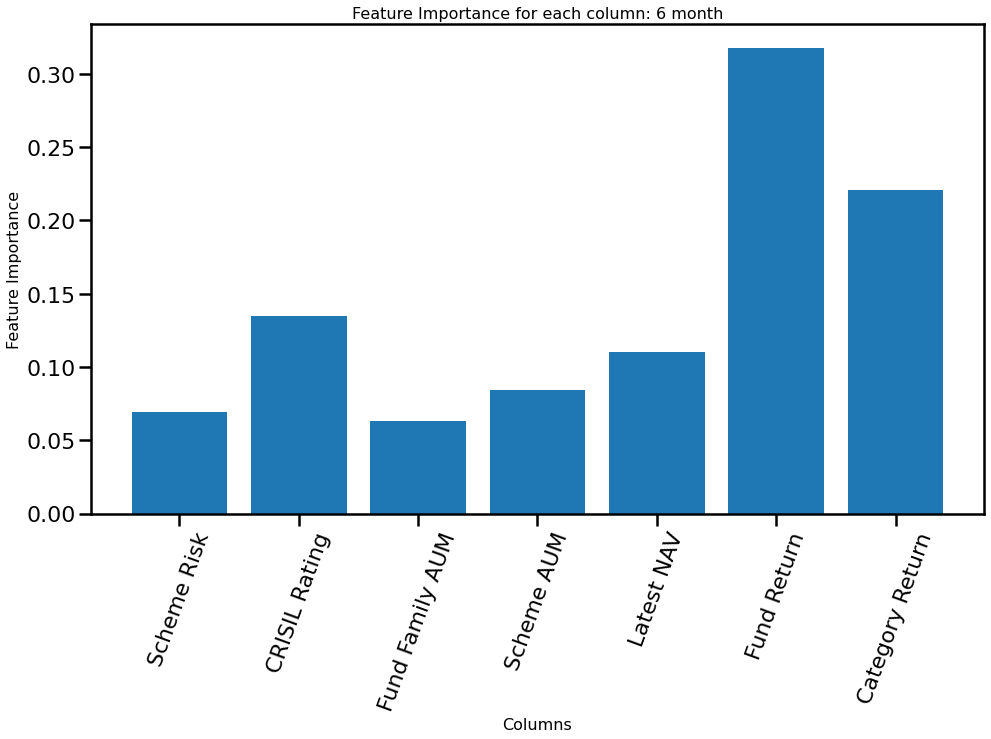

In [ ]:
# 6 month
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_6m)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 6 month', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

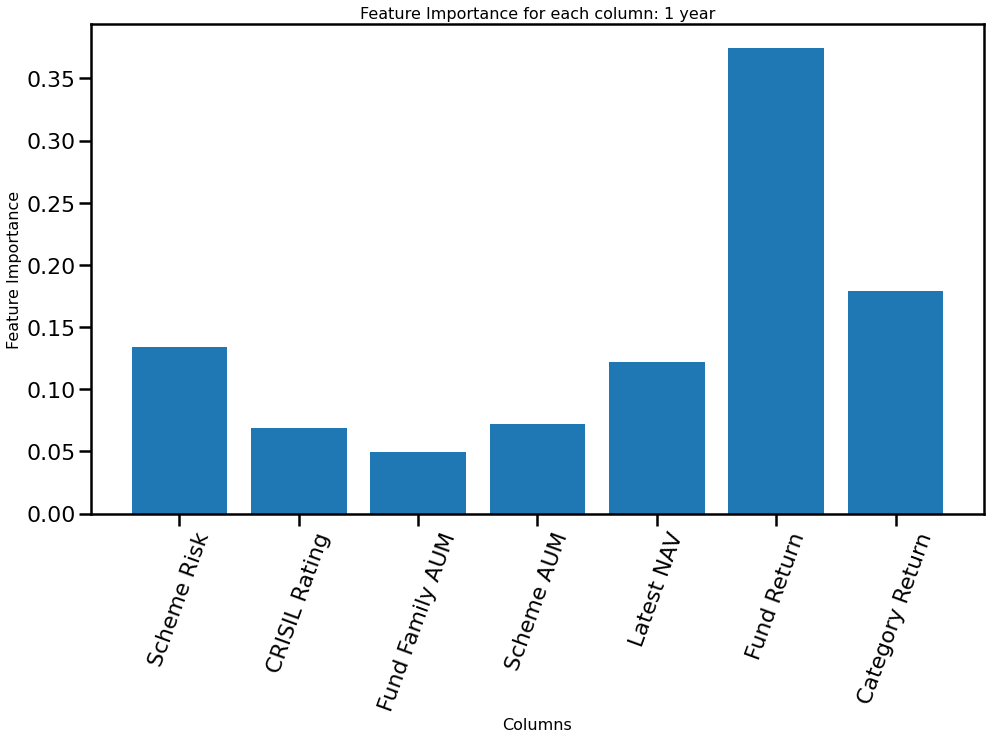

In [ ]:
# 1 year
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_1y)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 year', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

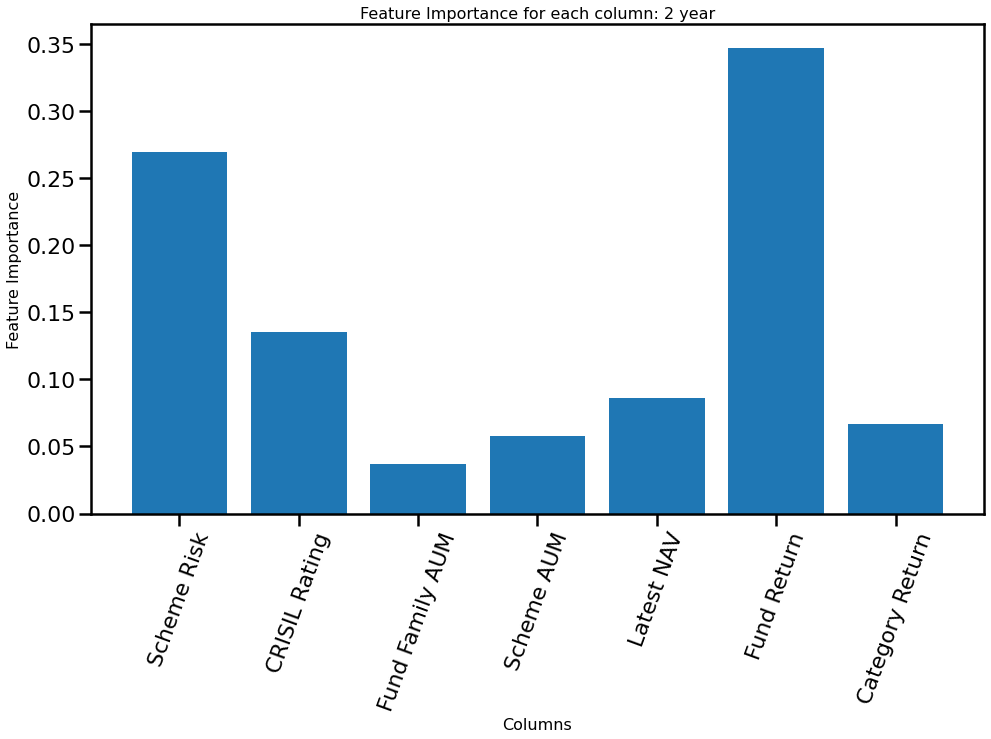

In [ ]:
# 2 year
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_2y)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 2 year', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

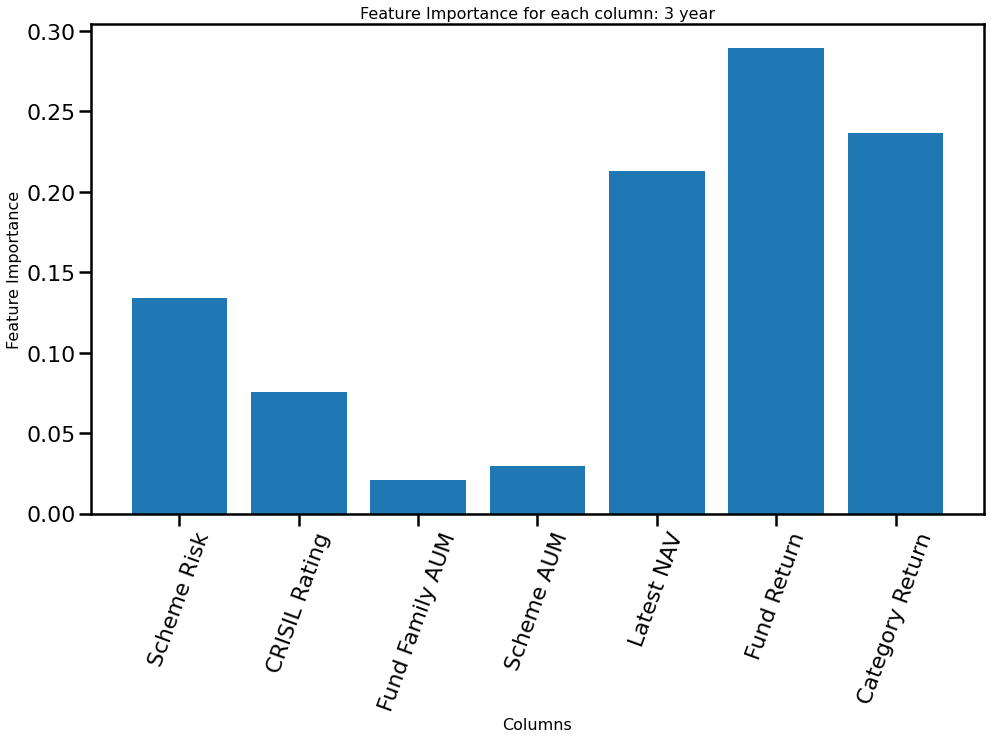

In [ ]:
# 3 year
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_3y)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 year', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

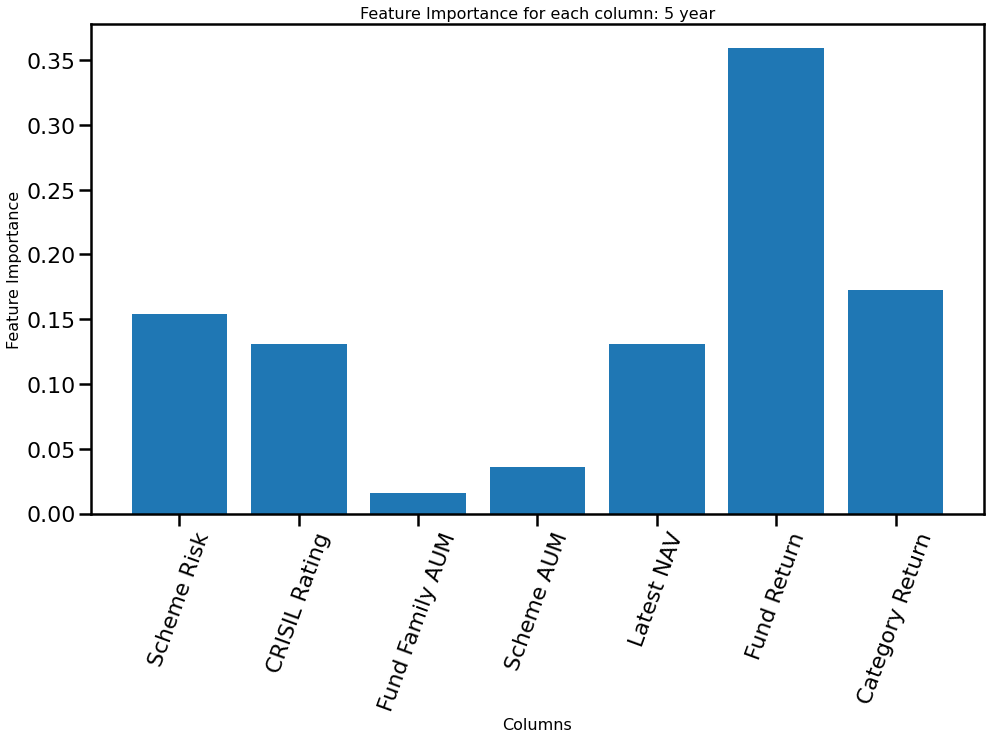

In [ ]:
# 5 year
plt.figure( figsize = (16, 9) )
plt.bar(columns, feature_imp_5y)

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 5 year', fontsize = 16)
plt.xticks(columns, rotation = 70)
plt.show()

# Give Predictions using trained models

In [ ]:
##
# Predict good and bad fund based on Random Forest Classification
##
Y_1m_predicted = clf_1m.predict( X_1m )
Y_3m_predicted = clf_3m.predict( X_3m )
Y_6m_predicted = clf_6m.predict( X_6m )
Y_1y_predicted = clf_1y.predict( X_1y )
Y_2y_predicted = clf_2y.predict( X_2y )
Y_3y_predicted = clf_3y.predict( X_3y )
Y_5y_predicted = clf_5y.predict( X_5y )

In [ ]:
## 
# List of good funds for each time frame
## 
good_funds_1m = [ fund_schemes[k] for (k, v) in enumerate( Y_1m_predicted ) if v == 1.0 ]
good_funds_3m = [ fund_schemes[k] for (k, v) in enumerate( Y_3m_predicted ) if v == 1.0 ]
good_funds_6m = [ fund_schemes[k] for (k, v) in enumerate( Y_6m_predicted ) if v == 1.0 ]
good_funds_1y = [ fund_schemes[k] for (k, v) in enumerate( Y_1y_predicted ) if v == 1.0 ]
good_funds_2y = [ fund_schemes[k] for (k, v) in enumerate( Y_2y_predicted ) if v == 1.0 ]
good_funds_3y = [ fund_schemes[k] for (k, v) in enumerate( Y_3y_predicted ) if v == 1.0 ]
good_funds_5y = [ fund_schemes[k] for (k, v) in enumerate( Y_5y_predicted ) if v == 1.0 ]

In [ ]:
good_funds_1m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1m]

good_funds_3m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3m]

good_funds_6m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_6m]

good_funds_1y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1y]

good_funds_2y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_2y]

good_funds_3y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3y]

good_funds_5y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_5y]

In [ ]:
good_funds_1m_sort.sort(key = lambda x: x[1], reverse=True)
good_funds_3m_sort.sort(key = lambda x: x[2], reverse=True)
good_funds_6m_sort.sort(key = lambda x: x[3], reverse=True)
good_funds_1y_sort.sort(key = lambda x: x[4], reverse=True)
good_funds_2y_sort.sort(key = lambda x: x[5], reverse=True)
good_funds_3y_sort.sort(key = lambda x: x[6], reverse=True)
good_funds_5y_sort.sort(key = lambda x: x[7], reverse=True)

print( '## Top 5 funds for a timeframe of 1 month:')
for x in good_funds_1m_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()


print( '## Top 5 funds for a timeframe of 3 months:')
for x in good_funds_3m_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

print( '## Top 5 funds for a timeframe of 6 months:')
for x in good_funds_6m_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

print( '## Top 5 funds for a timeframe of 1 year:')
for x in good_funds_1y_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

print( '## Top 5 funds for a timeframe of 2 years:')
for x in good_funds_2y_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

print( '## Top 5 funds for a timeframe of 3 years:')
for x in good_funds_3y_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

print( '## Top 5 funds for a timeframe of 5 years:')
for x in good_funds_5y_sort[:5]:
  print("Scheme Name = ",x[0])
  print("Return 1 month = ",x[1],"%")
  print("Return 3 month = ",x[2],"%")
  print("Return 6 month = ",x[3],"%")
  print("Return 1 year = ",x[4],"%")
  print("Return 2 year = ",x[5],"%")
  print("Return 3 year = ",x[6],"%")
  print("Return 5 year = ",x[7],"%")
  print("Scheme URL = ",x[8])
  print()

## Top 5 funds for a timeframe of 1 month:
Scheme Name =  SBI - ETF Nifty Bank
Return 1 month =  20.24 %
Return 3 month =  32.83 %
Return 6 month =  63.74 %
Return 1 year =  -8.12 %
Return 2 year =  10.64 %
Return 3 year =  12.38 %
Return 5 year =  71.71 %
Scheme URL =  http://www.moneycontrol.com/mutual-funds/nav/sbi-etf-nifty-bank/MSB1111

Scheme Name =  ICICI Prudential Banking & Financial Services Fund - Direct Plan (G)
Return 1 month =  14.66 %
Return 3 month =  20.43 %
Return 6 month =  53.48 %
Return 1 year =  -9.72 %
Return 2 year =  7.5 %
Return 3 year =  1.84 %
Return 5 year =  81.56 %
Scheme URL =  http://www.moneycontrol.com/mutual-funds/nav/icici-prudential-banking-financial-services-fund-direct-plan/MPI1138

Scheme Name =  ICICI Prudential Banking & Financial Services Fund - Retail Plan (G)
Return 1 month =  14.57 %
Return 3 month =  20.15 %
Return 6 month =  52.73 %
Return 1 year =  -10.55 %
Return 2 year =  5.51 %
Return 3 year =  -1.24 %
Return 5 year =  71.74 %
Scheme